Pour ce notebook, nous nous plaçons dans le contexte suivant :    
  * Nous sommes des data analyst pour le RC lens et la saison vient de se finir, le coach et la direction veulent faire un bilan de cette saison pour préparer au mieux la saison prochaine.
  * Nous avons comme consigne de comprendre comment l'équipe c'est hissé aussi haut.
  * Pour cela nous regarderons quelles sont les statistiques qui ont une grandes influence sur le classement.
  * Puis nous comparerons les équipes entre elles pour voir nos points forts et nos points faibles.
  * Nous finirons avec des analyses de certains matchs clés et autres.

  ![Rc Lens](https://upload.wikimedia.org/wikipedia/fr/c/c5/Logo_RC_Lens.svg)
  

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# I) Commençons par importé nos données, regardons si les colonnes ont un nom explicite, sinon donné une definition. Ensuite regardons si les types de nos colonnes nous conviennent puis rajoutons les colonnes pouvant être utile.

## a) Ici deux jeux de données seront utilisé
* Stats_Equipe.csv pour avoir un résumé de plusieurs statistiques pour toute les équipes sur la saison.
* Stats_Match.csv pour avoir un résumé de tous les matchs de la saison.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.lines import Line2D
#drive.mount('/content/drive')
pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#dfM=pd.read_csv("/content/drive/MyDrive/Stats_Match.csv",sep=";")
#dfE=pd.read_csv("/content/drive/MyDrive/Stats_Equipe.csv",sep=";")
dfM=pd.read_csv("Stats_Match.csv",sep=";")
dfE=pd.read_csv("Stats_Equipe.csv",sep=";")

## b) Ici nous ajoutons deux nouvelles colonnes qui nous serons utile plus tard puis nous renommons 3 colonnes pour que leurs noms soit un peu plus explicite.
- Après quelques retypage nos colonnes nous conviennent

In [ ]:
dfE['GA/90']=dfE['GA']/38
dfE['Gls-xG']=dfE['Gls']-dfE['xG']
dfE.rename(columns={"# Pl": "NbrJoueur","Age": "AgeMoy","Poss": "PossMoy"},inplace=True)
dfE.dtypes

Squad                object
NbrJoueur             int64
AgeMoy              float64
PossMoy             float64
MP                    int64
Starts                int64
Min                   int64
90s                   int64
Gls                   int64
Ast                   int64
G+A                   int64
G-PK                  int64
PK                    int64
PKatt                 int64
CrdY                  int64
CrdR                  int64
xG                  float64
G-xG                float64
npxG                float64
xAG                 float64
npxG+xAG            float64
PrgC                  int64
PrgP                  int64
Gls/90              float64
Ast/90              float64
G+A/90              float64
G-PK/90             float64
G+A-PK/90           float64
xG/90               float64
xAG/90              float64
xG+xAG/90           float64
npxG/90             float64
npxG+xAG/90         float64
W                     int64
D                     int64
L                   

In [ ]:
dfM['B365H'] = dfM['B365H'].str.replace(',', '.').astype(float)
dfM['B365D'] = dfM['B365D'].str.replace(',', '.').astype(float)
dfM['B365A'] = dfM['B365A'].str.replace(',', '.').astype(float)
dfM['H_xG'] = dfM['H_xG'].str.replace(',', '.').astype(float)
dfM['A_xG'] = dfM['A_xG'].str.replace(',', '.').astype(float)
dfM['Affluence'] = dfM['Affluence'].str.replace(',', '').astype(int)
# Fonction pour multiplier par 100 si la valeur est inférieure à 100
def multiply_if_less_than_100(value):
    if value < 100:
        return value * 100
    else:
        return value

# Application de la fonction à la colonne 'Affluence'
dfM['Affluence'] = dfM['Affluence'].apply(multiply_if_less_than_100)

dfM['xDiff'] = dfM['xDiff'].str.replace(',', '.')
dfM.dtypes

Div           object
Date          object
Time          object
HomeTeam      object
AwayTeam      object
FTHG           int64
FTAG           int64
FTR           object
HTHG           int64
HTAG           int64
HTR           object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
B365H        float64
B365D        float64
B365A        float64
H_xG         float64
A_xG         float64
Affluence      int64
xDiff         object
xRes          object
dtype: object

Squad = Nom de l'équipe \
NbrJoueur = Nombre de joueurs \
AgeMoy = Âge moyen des joueurs de l'équipe \
MP = Nombre de match joué \
Starts = Nombre de joueurs ayant commencé le match \
Min = Nombre de minute joué \
90s = Nombre de match joué \
Gls = Nombre de matchs \
Ast = Nombre de passes décisives \
G+A = Nombre de passes décisives + Buts \
G - PK = Nombre de buts marqué sans les penaltys \
PK = Nombre de penaltys marqués \
PKatt = Nombre de penaltys Tirés \
CrdY = Nombre de cartons jaunes \
CrdR = Nombre de de cartons rouges \
xG = Nombre de but attendus (algo qui calcul la chance de marqué un but) \
G-xG = Nombre de but marqué - ceux attendus (efficacité d'une équipe) \
npxG = Nombre buts attendus sans les penaltys \
xAG = Buts assisté attendus = xG attendu après une passe \
npxG+xAG = Buts attendus hors penaltys + buts assistés \
PrgC = Possessions progressives \
PrgP = Passes progressives \
Gls/90 = Nombre de buts par match \
Ast/90 = Nombre de passes décisives par match \
G+A/90 = Nombre de buts + passes décisives par match \
G-PK/90 = Nombre de buts sans les penaltys par match \
G+A-PK/90 = Nombre de buts + passes décisives sans les penaltys par match \
xG/90 = Nombre de but attendus par match \
xAG/90 = Nombre de but assisté attendus par match \
xG+xAG/90 = Nombre de but + nombre de buts assisté attendu par match \
npxG/90 = Nombre de but attendus sans les penaltys par match \
npxG+xAG/90 = Nombre de but sans les penaltys + nombre de but assisté attendus par match \
W = Nombre de victoire \
D = Nombre de nul \
L = Nombre de défaite \
Rk = Classement \
Pts = Nombre de points \
pts/MP = Nombre de points par match \
Attendance = Affluence \
Shots = Nombre de tirs \
Pass_Cmp = Nombre de passes complétées \
Pass_Att = Nombre de passes tentées \
PSxG = Nombre de buts encaissés attendus \
PSxG+/- = Différence entre le nombre buts encaissés attendus et réel \
GA = But encaissé
DistTrav = Distance parcourue par les joueurs durant les matchs \
Budget = Budget du club (Mercato + Masse salariale + toutes les dépenses diverses)
GA/90 = Nombre de buts encaissés par match





In [ ]:
dfE.head(20)

,Squad,NbrJoueur,AgeMoy,PossMoy,MP,Starts,Min,90s,Gls,Ast,G+A,G-PK,PK,PKatt,CrdY,CrdR,xG,G-xG,npxG,xAG,npxG+xAG,PrgC,PrgP,Gls/90,Ast/90,G+A/90,G-PK/90,G+A-PK/90,xG/90,xAG/90,xG+xAG/90,npxG/90,npxG+xAG/90,W,D,L,Rk,Pts,Pts/MP,Attendance,Shots,Pass_Cmp,Pass_Att,PSxG,PSxG+/-,GA,DistTrav,Budget(Millions),TirConc,GA/90,Gls-xG
0,Ajaccio,36,29.1,43.2,38,418,3420,38,22,12,34,16,6,9,86,10,36.1,-14.1,29.4,22.7,52.1,487,1169,0.58,0.32,0.89,0.42,0.74,0.95,0.60,1.55,0.77,1.37,7,5,26,18,26,0.68,7369,311,11216,15286,57.6,-14.4,74,73525,22,410,1.947368,-14.1
1,Angers,33,25.7,46.9,38,418,3420,38,31,18,49,27,4,4,69,5,40.9,-9.9,37.8,28.0,65.7,632,1393,0.82,0.47,1.29,0.71,1.18,1.08,0.74,1.81,0.99,1.73,4,6,28,20,18,0.47,9630,367,14103,17463,67.8,-9.2,81,89958,40,452,2.131579,-9.9
2,Auxerre,33,27.3,43.3,38,418,3420,38,32,17,49,25,7,9,54,6,42.9,-10.9,35.9,27.4,63.3,531,1284,0.84,0.45,1.29,0.66,1.11,1.13,0.72,1.85,0.94,1.67,8,11,19,17,35,0.92,15606,420,12386,15989,57.8,-4.2,63,80840,32,466,1.657895,-10.9
3,Brest,29,26.6,44.9,38,418,3420,38,43,28,71,36,7,8,63,2,43.3,-0.3,37.1,29.6,66.7,592,1311,1.13,0.74,1.87,0.95,1.68,1.14,0.78,1.92,0.98,1.76,11,11,16,14,44,1.16,12667,417,12486,16452,55.1,3.1,54,82689,48,480,1.421053,-0.3
4,Clermont Foot,28,27.2,48.3,38,418,3420,38,44,26,70,37,7,10,72,5,47.5,-3.5,39.6,27.7,67.4,532,1304,1.16,0.68,1.84,0.97,1.66,1.25,0.73,1.98,1.04,1.77,17,8,13,8,59,1.55,11270,393,14212,17961,56.5,7.5,49,89656,25,475,1.289474,-3.5
5,Lens,29,26.4,55.6,38,418,3420,38,66,49,115,60,6,9,63,3,66.7,-0.7,59.8,47.4,107.2,738,1829,1.74,1.29,3.03,1.58,2.87,1.76,1.25,3.00,1.57,2.82,25,9,4,2,84,2.21,37652,518,17809,21203,34.0,6.0,29,112844,62,389,0.763158,-0.7
6,Lille,26,26.0,60.5,38,418,3420,38,65,40,105,54,11,12,82,1,68.7,-3.7,60.0,46.4,106.5,798,1982,1.71,1.05,2.76,1.42,2.47,1.81,1.22,3.03,1.58,2.80,19,10,9,5,67,1.76,36148,545,19266,22826,39.2,-1.8,44,112069,100,324,1.157895,-3.7
7,Lorient,30,25.2,46.6,38,418,3420,38,49,32,81,45,4,6,48,4,44.5,4.5,39.8,29.4,69.2,753,1329,1.29,0.84,2.13,1.18,2.03,1.17,0.77,1.94,1.05,1.82,15,10,13,10,55,1.45,14992,397,14837,18087,52.4,0.4,53,97993,50,563,1.394737,4.5
8,Lyon,29,25.5,58.1,38,418,3420,38,63,45,108,57,6,8,61,3,61.1,1.9,54.8,45.1,99.9,709,1883,1.66,1.18,2.84,1.50,2.68,1.61,1.19,2.80,1.44,2.63,18,8,12,7,62,1.63,46058,511,18956,22698,50.2,6.2,47,110348,250,417,1.236842,1.9
9,Marseille,30,27.3,56.7,38,418,3420,38,61,38,99,55,6,7,63,4,65.3,-4.3,60.0,47.0,107.0,759,1919,1.61,1.00,2.61,1.45,2.45,1.72,1.24,2.95,1.58,2.82,22,7,9,3,73,1.92,62687,546,16817,20689,37.7,0.7,40,107143,250,422,1.052632,-4.3


Div = Ligue 1 \
Date = Date du match \
Time = Heure du match \
HomeTeam = Equipe à domicile \
AwayTeam = Equipe à l'extérieur \
FTHG = Nombre de but de l'équipe à domicile \
FTAG = Nombre de but de l'équipe à l'extérieur \
FTR = Résultat du match (H = victoire Home, D = draw, A = victoire Away) \
HTHG = Nombre de but de l'équipe à domicile en première mi-temps \
HTAG = Nombre de but de l'équipe à l'extérieur en première mi-temps \
HTR	= Résultat à la mi-temps (H = victoire Home, D = draw, A = victoire Away) \
HS = Nombre de tirs de l'équipe à domicile \
AS = Nombre de tirs de l'équipe à l'extérieur \
HST	= Nombre de tirs cadrés de l'équipe à domicile \
AST	= Nombre de tirs cadrés de l'équipe à l'extérieur \
HF	= Nombre de fautes de l'équipe à domicile \
AF	= Nombre de fautes de l'équipe à l'exterieur \
HC	= Nombre de corners de l'équipe à domicile \
AC	= Nombre de corners de l'équipe à l'exterieur \
HY	= Nombre de cartons jaune de l'équipe à domicile \
AY	= Nombre de cartons jaune de l'équipe à l'exterieur \
HR	= Nombre de cartons rouge de l'équipe à domicile \
AR	= Nombre de cartons rouge de l'équipe à l'exterieur \
B365H	= Côte de la victoire de l'équipe à domicile \
B365D	= Côte du match nul \
B365A	= Côte de la victoire de l'équipe à l'exterieur \
H_xG	= Nombre de but attendus par l'équipe à domicile \
A_xG	= Nombre de but attendus par l'équipe à l'exterieur \
Affluence	= Affluence \
xDiff	= Différence de but attendus (pour ensuite dire qui aurait du gagné) \
xRes = Qui aurait "du" gagner (H = victoire Home, D = draw, A = victoire Away) \

In [ ]:
dfM.head(75)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,H_xG,A_xG,Affluence,xDiff,xRes
0,F1,05/08/2022,20:00:00,Lyon,Ajaccio,2,1,H,2,1,H,11,8,6,4,10,18,4,3,1,6,1,1,1.33,5.25,8.50,1.3,1.5,48516,-0.2,D
1,F1,06/08/2022,16:00:00,Strasbourg,Monaco,1,2,A,0,1,A,11,24,7,11,18,15,3,7,0,2,0,0,2.62,3.25,2.75,0.8,2.8,25359,-2,A
2,F1,06/08/2022,20:00:00,Clermont Foot,Paris S-G,0,5,A,0,3,A,7,18,1,12,13,13,0,6,2,1,0,0,9.50,6.50,1.25,0.3,3.5,12203,-3.2,A
3,F1,07/08/2022,12:00:00,Toulouse,Nice,1,1,D,1,0,H,6,11,4,4,10,8,6,3,1,2,0,0,2.87,3.30,2.50,0.9,1.2,20567,-0.3,D
4,F1,07/08/2022,14:00:00,Angers,Nantes,0,0,D,0,0,D,16,14,6,4,15,13,3,6,3,3,0,0,2.70,3.25,2.70,2.5,1.2,37015,1.3,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,F1,16/09/2022,20:00:00,Auxerre,Lorient,1,3,A,0,3,A,17,12,5,8,13,11,9,5,3,1,0,0,2.70,3.30,2.60,2.0,2.5,14866,-0.5,D
71,F1,17/09/2022,16:00:00,Montpellier,Strasbourg,2,1,H,1,0,H,10,8,4,2,11,20,8,6,4,4,0,0,2.45,3.60,2.70,1.8,0.6,1078,1.2,H
72,F1,17/09/2022,20:00:00,Lille,Toulouse,2,1,H,1,0,H,10,14,4,5,20,14,5,7,2,0,0,0,1.75,3.90,4.50,1.0,0.8,33635,0.2,D
73,F1,18/09/2022,12:00:00,Reims,Monaco,0,3,A,0,0,D,9,20,2,11,14,16,5,4,3,3,1,0,3.10,3.50,2.25,0.6,1.7,1000,-1.1,A


# II) Nous allons voir avec un premier coup d'oeil quelles sont les statistiques importantes pour être bien classé


## a) Commençons par regarder le classement de nos équipes et voir si des statistiques nous sautent aux yeux.

In [ ]:
dfE.sort_values(by=["Rk"])

,Squad,NbrJoueur,AgeMoy,PossMoy,MP,Starts,Min,90s,Gls,Ast,G+A,G-PK,PK,PKatt,CrdY,CrdR,xG,G-xG,npxG,xAG,npxG+xAG,PrgC,PrgP,Gls/90,Ast/90,G+A/90,G-PK/90,G+A-PK/90,xG/90,xAG/90,xG+xAG/90,npxG/90,npxG+xAG/90,W,D,L,Rk,Pts,Pts/MP,Attendance,Shots,Pass_Cmp,Pass_Att,PSxG,PSxG+/-,GA,DistTrav,Budget(Millions),TirConc,GA/90,Gls-xG
14,Paris S-G,26,26.9,60.7,38,418,3420,38,86,62,148,81,5,7,57,5,78.2,7.8,72.6,56.8,129.3,810,2029,2.26,1.63,3.89,2.13,3.76,2.06,1.49,3.55,1.91,3.40,27,4,7,1,85,2.24,46334,562,23694,26476,43.3,4.3,40,129073,700,442,1.052632,7.8
5,Lens,29,26.4,55.6,38,418,3420,38,66,49,115,60,6,9,63,3,66.7,-0.7,59.8,47.4,107.2,738,1829,1.74,1.29,3.03,1.58,2.87,1.76,1.25,3.00,1.57,2.82,25,9,4,2,84,2.21,37652,518,17809,21203,34.0,6.0,29,112844,62,389,0.763158,-0.7
9,Marseille,30,27.3,56.7,38,418,3420,38,61,38,99,55,6,7,63,4,65.3,-4.3,60.0,47.0,107.0,759,1919,1.61,1.00,2.61,1.45,2.45,1.72,1.24,2.95,1.58,2.82,22,7,9,3,73,1.92,62687,546,16817,20689,37.7,0.7,40,107143,250,422,1.052632,-4.3
16,Rennes,32,25.2,55.4,38,418,3420,38,66,47,113,63,3,3,58,6,61.4,4.6,59.0,45.4,104.4,774,1922,1.74,1.24,2.97,1.66,2.89,1.62,1.20,2.81,1.55,2.75,21,5,12,4,68,1.79,27722,526,17618,21193,38.9,0.9,39,109626,90,370,1.026316,4.6
6,Lille,26,26.0,60.5,38,418,3420,38,65,40,105,54,11,12,82,1,68.7,-3.7,60.0,46.4,106.5,798,1982,1.71,1.05,2.76,1.42,2.47,1.81,1.22,3.03,1.58,2.80,19,10,9,5,67,1.76,36148,545,19266,22826,39.2,-1.8,44,112069,100,324,1.157895,-3.7
10,Monaco,27,24.7,48.2,38,418,3420,38,69,47,116,64,5,8,64,5,62.1,6.9,55.7,42.2,97.9,719,1820,1.82,1.24,3.05,1.68,2.92,1.63,1.11,2.74,1.47,2.58,19,8,11,6,65,1.71,7095,470,14414,18378,49.5,-5.5,58,91223,240,507,1.526316,6.9
8,Lyon,29,25.5,58.1,38,418,3420,38,63,45,108,57,6,8,61,3,61.1,1.9,54.8,45.1,99.9,709,1883,1.66,1.18,2.84,1.50,2.68,1.61,1.19,2.80,1.44,2.63,18,8,12,7,62,1.63,46058,511,18956,22698,50.2,6.2,47,110348,250,417,1.236842,1.9
4,Clermont Foot,28,27.2,48.3,38,418,3420,38,44,26,70,37,7,10,72,5,47.5,-3.5,39.6,27.7,67.4,532,1304,1.16,0.68,1.84,0.97,1.66,1.25,0.73,1.98,1.04,1.77,17,8,13,8,59,1.55,11270,393,14212,17961,56.5,7.5,49,89656,25,475,1.289474,-3.5
13,Nice,34,26.5,51.5,38,418,3420,38,47,32,79,41,6,7,53,3,57.2,-10.2,51.7,39.3,91.1,774,1534,1.24,0.84,2.08,1.08,1.92,1.51,1.04,2.54,1.36,2.40,15,13,10,9,58,1.53,22286,507,17325,20784,39.0,2.0,37,107128,100,441,0.973684,-10.2
7,Lorient,30,25.2,46.6,38,418,3420,38,49,32,81,45,4,6,48,4,44.5,4.5,39.8,29.4,69.2,753,1329,1.29,0.84,2.13,1.18,2.03,1.17,0.77,1.94,1.05,1.82,15,10,13,10,55,1.45,14992,397,14837,18087,52.4,0.4,53,97993,50,563,1.394737,4.5


Ici nous pouvons remarquer que beaucoup de statistiques ont l'air de joué un grand rôle dans le classement de l'équipe (Tirs, buts , xG , PrgP, W, PSxG+/- etc)
Nous allons maintenant voir si il y a de réel corélation entre ses statistiques et le classement

## b) Prenons un point de vue global sur les buts marqués/encaissés et la différence dans la ligue

<ipython-input-185-1719feb2673d>:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



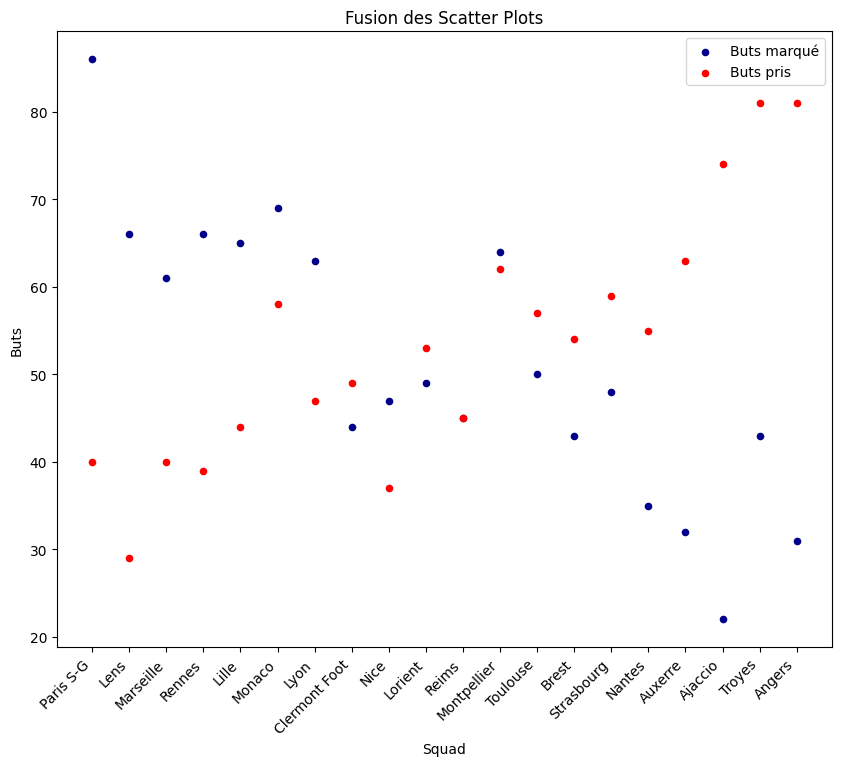

In [ ]:
8# Créer une figure avec un seul axe
fig, ax = plt.subplots(figsize=(10, 8))

# Premier scatter plot
dfE.sort_values(by=["Rk"]).plot.scatter(x='Squad', y='Gls', c='DarkBlue', ax=ax, label='Buts marqué')

# Deuxième scatter plot
dfE.sort_values(by=["Rk"]).plot.scatter(x='Squad', y='GA', c='Red', ax=ax, label='Buts pris')

# Ajuster l'espacement des étiquettes sur l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Ajouter une légende
ax.legend()

# Ajouter des étiquettes et un titre
ax.set_xlabel('Squad')
ax.set_ylabel('Buts')
ax.set_title('Fusion des Scatter Plots')

# Afficher le graphique
plt.show()

<ipython-input-186-619cd775b62c>:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0, 0, 'Paris S-G'),
 Text(1, 0, 'Lens'),
 Text(2, 0, 'Marseille'),
 Text(3, 0, 'Rennes'),
 Text(4, 0, 'Lille'),
 Text(5, 0, 'Monaco'),
 Text(6, 0, 'Lyon'),
 Text(7, 0, 'Clermont Foot'),
 Text(8, 0, 'Nice'),
 Text(9, 0, 'Lorient'),
 Text(10, 0, 'Reims'),
 Text(11, 0, 'Montpellier'),
 Text(12, 0, 'Toulouse'),
 Text(13, 0, 'Brest'),
 Text(14, 0, 'Strasbourg'),
 Text(15, 0, 'Nantes'),
 Text(16, 0, 'Auxerre'),
 Text(17, 0, 'Ajaccio'),
 Text(18, 0, 'Troyes'),
 Text(19, 0, 'Angers')]

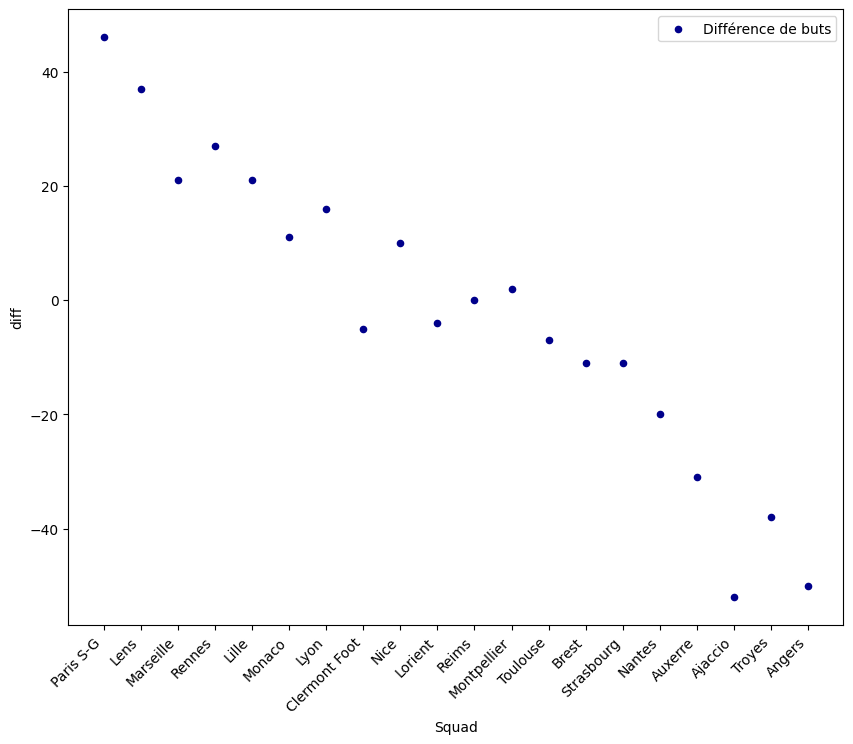

In [ ]:
# Créer une figure avec un seul axe
fig, ax = plt.subplots(figsize=(10, 8))
# Premier scatter plot
dfE['diff']=dfE['Gls']-dfE['GA']
dfE.sort_values(by=["Rk"]).plot.scatter(x='Squad', y='diff', c='DarkBlue', ax=ax, label='Différence de buts')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

## c) Regardons donc si il y a une corrélation entre le classement et ses statistiques

### 1) Commençons par le nombre de buts marqués et le classement


In [ ]:
cov=dfE["Rk"].cov(dfE["Gls"],ddof=0)
print(cov)

-76.125


In [ ]:
std_dev_Rk = dfE['Rk'].std(ddof=0)
print(std_dev_Rk)

5.766281297335398


In [ ]:
std_dev_Gls = dfE['Gls'].std(ddof=0)
print(std_dev_Gls)

15.337780152290618


In [ ]:
cov / (std_dev_Rk * std_dev_Gls)

-0.8607340276704327

In [ ]:
dfE['Rk'].corr(dfE['Gls'])

-0.8607340276704325

Le nombre de but marqué semble avoir une incidence sur le classement. Ce qui est logique car pour gagner des matchs il faut marquer et plus on marque plus on gagne donc plus on est haut dans le classement.

### 2) Regardons maintenant les buts encaissés et le classement
Ici nous utiliserons directement la fonction corr

In [ ]:
dfE['Rk'].corr(dfE['GA'])

0.8678642378926748

Ici le nombre du buts encaissés semble aussi être très important dans le classement

### 3) Pour finir regardons si la différence est aussi importante


In [ ]:
dfE['Rk'].corr(dfE['diff'])

-0.9583508944541609

Ici nous obtenons une corrélation encore plus élevée. Cela peut s'interprété par le fait qu'il faut beaucoup marqué en essayant d'en prendre le moins possible.
(La meilleure défense c'est l'attaque)

# III) Maintenant comparons les équipes

## a) Comparaison individuelle

In [ ]:
import plotly.graph_objects as go

categories = ['Gls/90','Ast/90','G+A/90','G-PK/90','G+A-PK/90','xG/90','xAG/90','xG+xAG/90','npxG/90','npxG+xAG/90','GA/90']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[dfE[dfE['Squad'] == 'Lens']['Gls/90'].values[0], dfE[dfE['Squad'] == 'Lens']['Ast/90'].values[0],dfE[dfE['Squad'] == 'Lens']['G+A/90'].values[0],
         dfE[dfE['Squad'] == 'Lens']['G-PK/90'].values[0],dfE[dfE['Squad'] == 'Lens']['G+A-PK/90'].values[0],dfE[dfE['Squad'] == 'Lens']['xG/90'].values[0],
         dfE[dfE['Squad'] == 'Lens']['xAG/90'].values[0],dfE[dfE['Squad'] == 'Lens']['xG+xAG/90'].values[0],dfE[dfE['Squad'] == 'Lens']['npxG/90'].values[0],dfE[dfE['Squad'] == 'Lens']['npxG+xAG/90'].values[0],
         dfE[dfE['Squad'] == 'Lens']['GA/90'].values[0]],
      theta=categories,
      fill='toself',
      name='Lens'
))
fig.add_trace(go.Scatterpolar(
      r=[dfE['Gls/90'].mean(), dfE['Ast/90'].mean(), dfE['G+A/90'].mean(),
         dfE['G-PK/90'].mean(), dfE['G+A-PK/90'].mean(),dfE['xG/90'].mean(),
         dfE['xAG/90'].mean(),dfE['xG+xAG/90'].mean(),dfE['npxG/90'].mean(),dfE['npxG+xAG/90'].mean(),
         dfE['GA/90'].mean()],
      theta=categories,
      fill='toself',
      name='moyenne'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 4]
    )),
  showlegend=True
)

fig.show()

Nous voyons avec ce graphique que Lens a été plus offensif que les autres équipes de ligue 1 et en plus elle a pris moitié moins de but, ce qui explique son bon classement.

In [ ]:
import plotly.graph_objects as go

categories = ['Gls/90','Ast/90','G+A/90','G-PK/90','G+A-PK/90','xG/90','xAG/90','xG+xAG/90','npxG/90','npxG+xAG/90','GA/90']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[dfE[dfE['Squad'] == 'Paris S-G']['Gls/90'].values[0], dfE[dfE['Squad'] == 'Paris S-G']['Ast/90'].values[0],dfE[dfE['Squad'] == 'Paris S-G']['G+A/90'].values[0],
         dfE[dfE['Squad'] == 'Paris S-G']['G-PK/90'].values[0],dfE[dfE['Squad'] == 'Paris S-G']['G+A-PK/90'].values[0],dfE[dfE['Squad'] == 'Paris S-G']['xG/90'].values[0],
         dfE[dfE['Squad'] == 'Paris S-G']['xAG/90'].values[0],dfE[dfE['Squad'] == 'Paris S-G']['xG+xAG/90'].values[0],dfE[dfE['Squad'] == 'Paris S-G']['npxG/90'].values[0],dfE[dfE['Squad'] == 'Paris S-G']['npxG+xAG/90'].values[0]
         ,dfE[dfE['Squad'] == 'Paris S-G']['GA/90'].values[0]],
      theta=categories,
      fill='toself',
      name='Paris S-G',
      line=dict(color='red')
))

fig.add_trace(go.Scatterpolar(
      r=[dfE[dfE['Squad'] == 'Lens']['Gls/90'].values[0], dfE[dfE['Squad'] == 'Lens']['Ast/90'].values[0],dfE[dfE['Squad'] == 'Lens']['G+A/90'].values[0],
         dfE[dfE['Squad'] == 'Lens']['G-PK/90'].values[0],dfE[dfE['Squad'] == 'Lens']['G+A-PK/90'].values[0],dfE[dfE['Squad'] == 'Lens']['xG/90'].values[0],
         dfE[dfE['Squad'] == 'Lens']['xAG/90'].values[0],dfE[dfE['Squad'] == 'Lens']['xG+xAG/90'].values[0],dfE[dfE['Squad'] == 'Lens']['npxG/90'].values[0],dfE[dfE['Squad'] == 'Lens']['npxG+xAG/90'].values[0],
         dfE[dfE['Squad'] == 'Lens']['GA/90'].values[0]],
      theta=categories,
      fill='toself',
      name='Lens',
      line=dict(color='blue')
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 4]
    )),
  showlegend=True
)

fig.show()

Malheureusement leur homologue Parisien ont réussi a encore plus être dangereux même si ils ont concédés un peu plus de buts, mais leur efficacité offensive explique surement pourquoi Paris a fini premier et lens deuxième.

In [ ]:
import plotly.graph_objects as go

categories = ['Gls/90','Ast/90','G+A/90','G-PK/90','G+A-PK/90','xG/90','xAG/90','xG+xAG/90','npxG/90','npxG+xAG/90','GA/90']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[dfE[dfE['Squad'] == 'Lens']['Gls/90'].values[0], dfE[dfE['Squad'] == 'Lens']['Ast/90'].values[0],dfE[dfE['Squad'] == 'Lens']['G+A/90'].values[0],
         dfE[dfE['Squad'] == 'Lens']['G-PK/90'].values[0],dfE[dfE['Squad'] == 'Lens']['G+A-PK/90'].values[0],dfE[dfE['Squad'] == 'Lens']['xG/90'].values[0],
         dfE[dfE['Squad'] == 'Lens']['xAG/90'].values[0],dfE[dfE['Squad'] == 'Lens']['xG+xAG/90'].values[0],dfE[dfE['Squad'] == 'Lens']['npxG/90'].values[0],dfE[dfE['Squad'] == 'Lens']['npxG+xAG/90'].values[0],
         dfE[dfE['Squad'] == 'Lens']['GA/90'].values[0]],
      theta=categories,
      fill='toself',
      name='Lens'
))

fig.add_trace(go.Scatterpolar(
      r=[dfE[dfE['Squad'] == 'Ajaccio']['Gls/90'].values[0], dfE[dfE['Squad'] == 'Ajaccio']['Ast/90'].values[0],dfE[dfE['Squad'] == 'Ajaccio']['G+A/90'].values[0],
         dfE[dfE['Squad'] == 'Ajaccio']['G-PK/90'].values[0],dfE[dfE['Squad'] == 'Ajaccio']['G+A-PK/90'].values[0],dfE[dfE['Squad'] == 'Ajaccio']['xG/90'].values[0],
         dfE[dfE['Squad'] == 'Ajaccio']['xAG/90'].values[0],dfE[dfE['Squad'] == 'Ajaccio']['xG+xAG/90'].values[0],dfE[dfE['Squad'] == 'Ajaccio']['npxG/90'].values[0],dfE[dfE['Squad'] == 'Ajaccio']['npxG+xAG/90'].values[0]
         ,dfE[dfE['Squad'] == 'Ajaccio']['GA/90'].values[0]],
      theta=categories,
      fill='toself',
      name='Ajaccio',
      line=dict(color='red')
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 4]
    )),
  showlegend=False
)

fig.show()

Ici une petit comparaison entre Lens et Ajaccio (équipe qui a marqué le moins de but la saison dernière). Avec ce graphique nous comprenons tout de suite la différence entre les équipes de bas de tableau et celles qui jouent l'europe

## b) Comparaison entre toutes les équipes


Nous poouvons nous amuser à créer des graphiques sur différentes statistique entre toute les équipes, la comparaison serait immédiate et très visuelle.

[0.17874453] -28.967656741796617


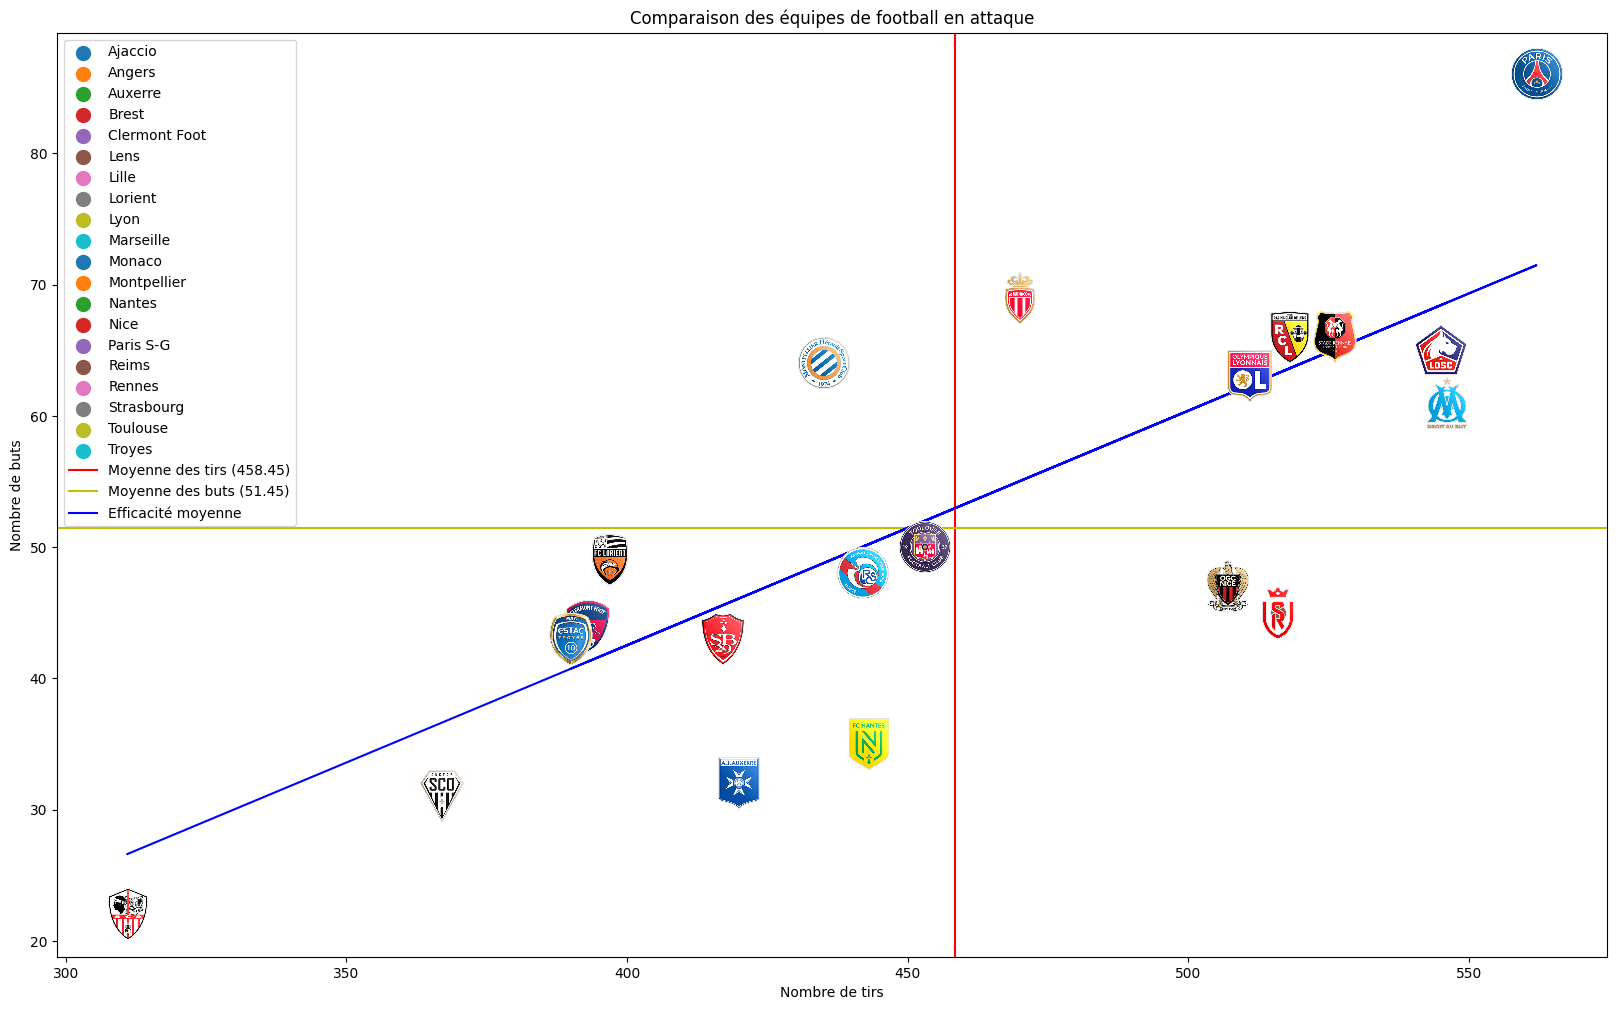

In [ ]:
mean_tirs = dfE['Shots'].mean()
mean_buts = dfE['Gls'].mean()

X = dfE[['Shots']]
y = dfE['Gls']

# Chemin du dossier contenant les logos
#images_folder = "/content/drive/MyDrive/Logos"
images_folder = "./Logos"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Charger les images des logos dans un dictionnaire
logo_images = {}
for filename in os.listdir(images_folder):
    if filename.endswith(".png"):  # Assurez-vous que seuls les fichiers PNG sont pris en compte
        team_name = filename.split(".")[0]  # Nom de l'équipe sans l'extension de fichier
        logo_images[team_name] = plt.imread(os.path.join(images_folder, filename))

# Création du graphique
plt.figure(figsize=(20, 12))

# Initialisation du modèle de régression linéaire
model = LinearRegression()

# Entraînement du modèle
model.fit(X_train, y_train)

# Coefficients de la droite de régression
coef = model.coef_
intercept = model.intercept_
print(coef, intercept)

# Plot
for i, row in dfE.iterrows():
    plt.scatter(row['Shots'], row['Gls'], label=row['Squad'], s=100)
    # Ajouter le logo de l'équipe
    if row['Squad'] in logo_images:
        imagebox = OffsetImage(logo_images[row['Squad']], zoom=0.2)
        ab = AnnotationBbox(imagebox, (row['Shots'], row['Gls']), frameon=False)
        plt.gca().add_artist(ab)



# Plot de la droite représentant la moyenne des tirs
plt.axvline(x=mean_tirs, color='r', linestyle='-', label=f'Moyenne des tirs ({mean_tirs:.2f})')

# Plot de la droite représentant la moyenne des buts
plt.axhline(y=mean_buts, color='y', linestyle='-', label=f'Moyenne des buts ({mean_buts:.2f})')

# Plot de la droite de régression
plt.plot(X, coef*X + intercept, color='b', linestyle='-', label='Efficacité moyenne')

# Labels des axes
plt.xlabel('Nombre de tirs')
plt.ylabel('Nombre de buts')

# Titre du graphique
plt.title('Comparaison des équipes de football en attaque')


plt.legend()


# Afficher le graphique
plt.show()


Ici nous pouvons interprété la regression linéaire de la manière suivante :
  * Si le club se trouve "au desssus de la droite" cela veut dire qu'il a été plus efficace en moyenne que les autres clubs.
  * Si le club se trouve "en dessous de la doite" cela veut dire qu'il a été moins efficace en moyenne que les autres clubs.
  * Nous pouvons voir que Lens est une équipe qui a été efficace.

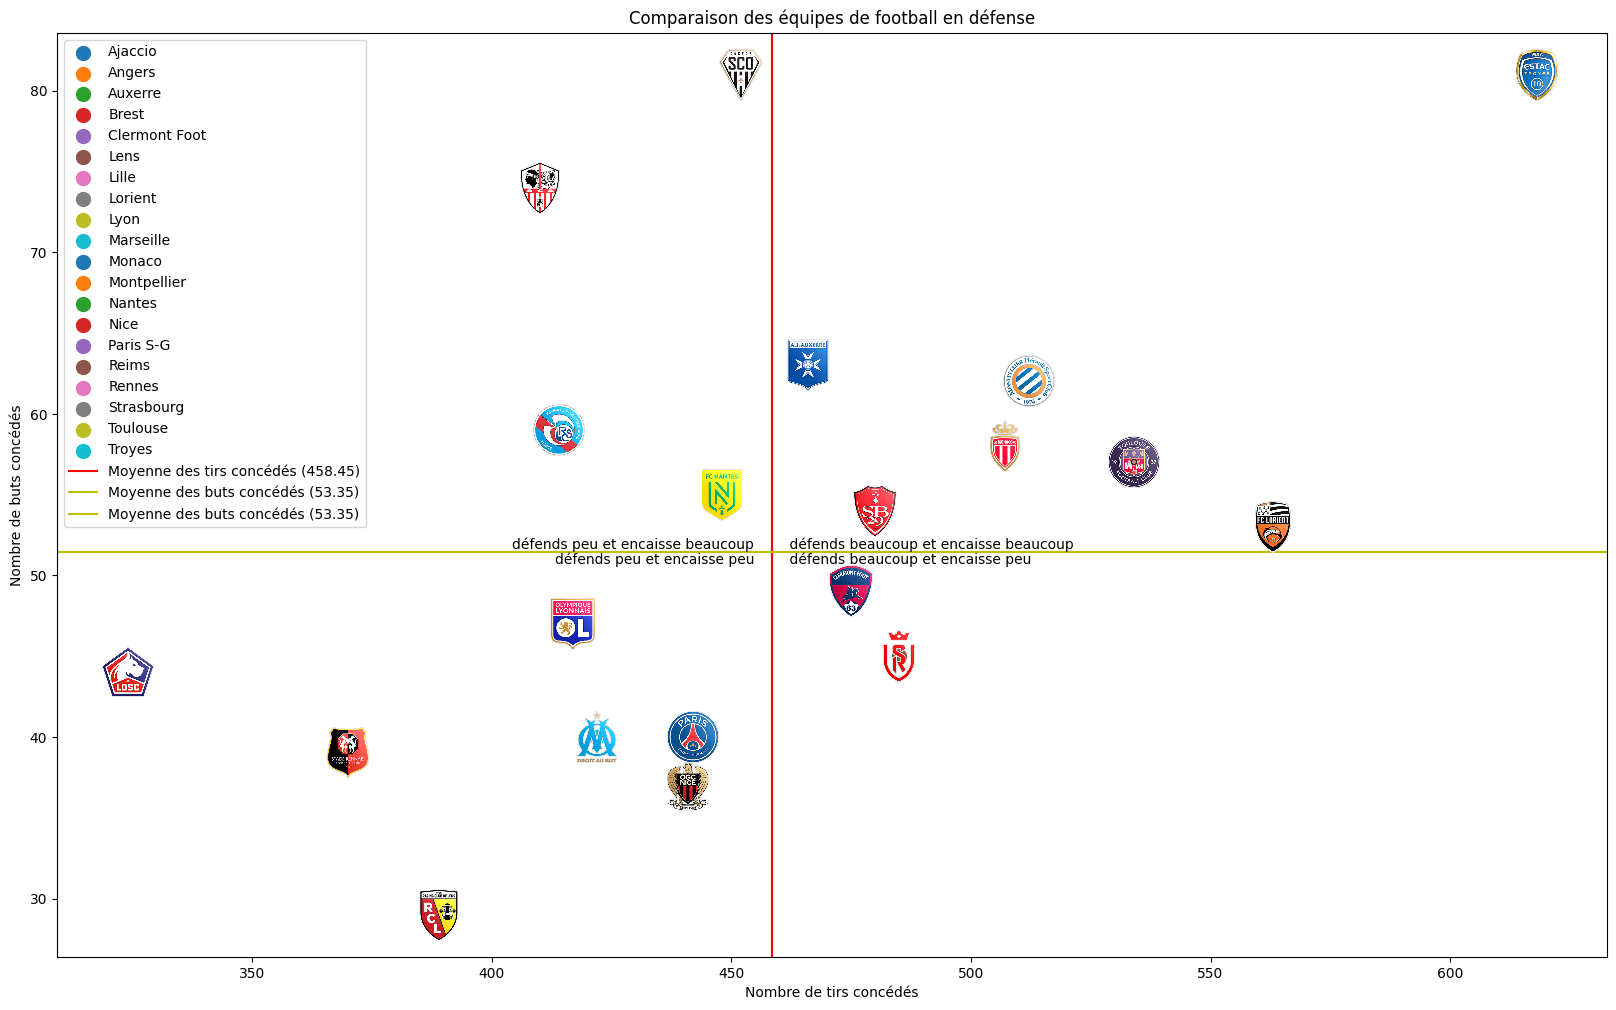

In [ ]:
mean_tirsConc = dfE['TirConc'].mean()
mean_butsConc = dfE['GA'].mean()

# Chemin du dossier contenant les logos
#images_folder = "/content/drive/MyDrive/Logos"
images_folder = "./Logos"

# Charger les images des logos dans un dictionnaire
logo_images = {}
for filename in os.listdir(images_folder):
    if filename.endswith(".png"):  # Assurez-vous que seuls les fichiers PNG sont pris en compte
        team_name = filename.split(".")[0]  # Nom de l'équipe sans l'extension de fichier
        logo_images[team_name] = plt.imread(os.path.join(images_folder, filename))

# Création du graphique
plt.figure(figsize=(20, 12))

# Plot
for i, row in dfE.iterrows():
    plt.scatter(row['TirConc'], row['GA'], label=row['Squad'], s=100)
    # Ajouter le logo de l'équipe
    if row['Squad'] in logo_images:
        imagebox = OffsetImage(logo_images[row['Squad']], zoom=0.2)
        ab = AnnotationBbox(imagebox, (row['TirConc'], row['GA']), frameon=False)
        plt.gca().add_artist(ab)


# Plot de la droite représentant la moyenne des tirs
plt.axvline(x=mean_tirs, color='r', linestyle='-', label=f'Moyenne des tirs concédés ({mean_tirsConc:.2f})')

# Plot de la droite représentant la moyenne des buts
plt.axhline(y=mean_buts, color='y', linestyle='-', label=f'Moyenne des buts concédés ({mean_butsConc:.2f})')


# Ajouter du texte à gauche de la ligne
plt.text(mean_tirsConc, mean_buts, f'défends peu et encaisse peu    ', ha='right', va='top')

# Ajouter du texte à gauche de la ligne
plt.text(mean_tirsConc, mean_buts, f'défends peu et encaisse beaucoup    ', ha='right', va='bottom')

# Ajouter du texte au-dessus de la ligne
plt.text(mean_tirsConc, mean_buts, f'    défends beaucoup et encaisse peu', ha='left', va='top')

# Ajouter du texte en-dessous de la ligne
plt.text(mean_tirsConc, mean_buts, f'    défends beaucoup et encaisse beaucoup', ha='left', va='bottom')

# Labels des axes
plt.xlabel('Nombre de tirs concédés')
plt.ylabel('Nombre de buts concédés')

# Titre du graphique
plt.title('Comparaison des équipes de football en défense')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

Ici nous divisons le graph en 4 rectangle avec chacun une interprétation, Cela est encore une autre manière d'interprété la comparaison entre les équipes.

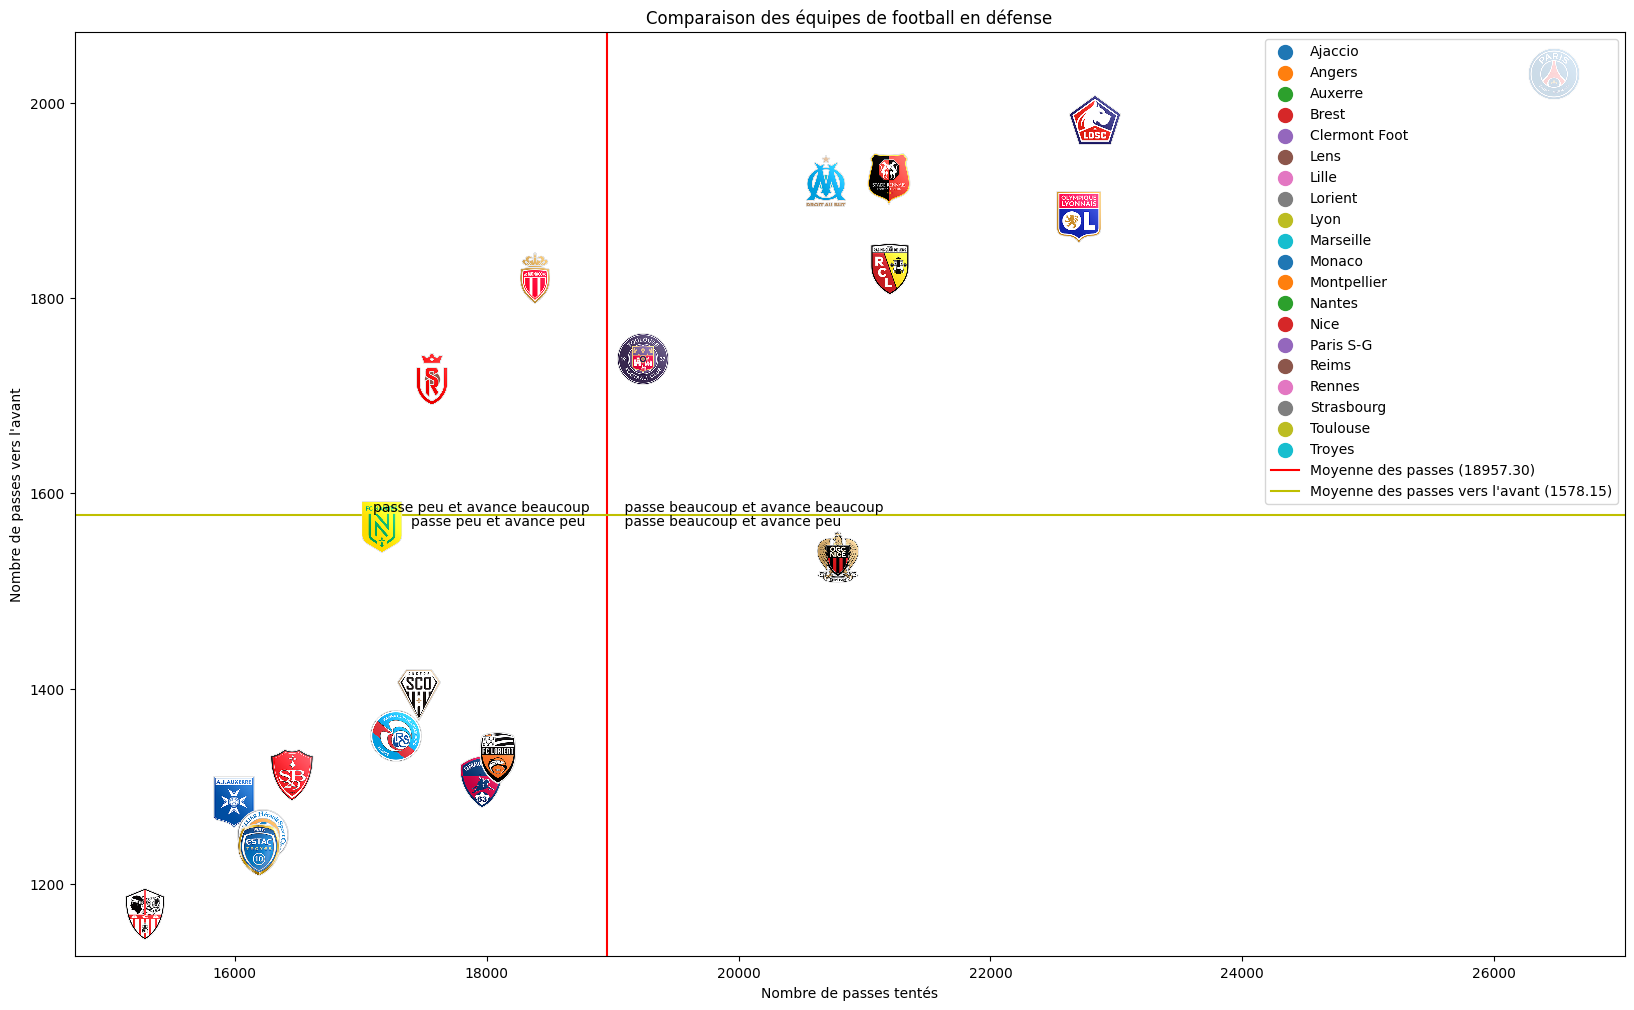

In [ ]:
mean_PrgP = dfE['PrgP'].mean()
mean_Pass_Att = dfE['Pass_Att'].mean()

# Chemin du dossier contenant les logos
#images_folder = "/content/drive/MyDrive/Logos"
images_folder = "./Logos"

# Charger les images des logos dans un dictionnaire
logo_images = {}
for filename in os.listdir(images_folder):
    if filename.endswith(".png"):  # Assurez-vous que seuls les fichiers PNG sont pris en compte
        team_name = filename.split(".")[0]  # Nom de l'équipe sans l'extension de fichier
        logo_images[team_name] = plt.imread(os.path.join(images_folder, filename))

# Création du graphique
plt.figure(figsize=(20, 12))

# Plot
for i, row in dfE.iterrows():
    plt.scatter(row['Pass_Att'], row['PrgP'], label=row['Squad'], s=100)
    # Ajouter le logo de l'équipe
    if row['Squad'] in logo_images:
        imagebox = OffsetImage(logo_images[row['Squad']], zoom=0.2)
        ab = AnnotationBbox(imagebox, (row['Pass_Att'], row['PrgP']), frameon=False)
        plt.gca().add_artist(ab)


# Plot de la droite représentant la moyenne des tirs
plt.axvline(x=mean_Pass_Att, color='r', linestyle='-', label=f'Moyenne des passes ({mean_Pass_Att:.2f})')

# Plot de la droite représentant la moyenne des buts
plt.axhline(y=mean_PrgP, color='y', linestyle='-', label=f'Moyenne des passes vers l\'avant ({mean_PrgP:.2f})')

# Ajouter du texte à gauche de la ligne
plt.text(mean_Pass_Att, mean_PrgP, f'passe peu et avance peu     ', ha='right', va='top')

# Ajouter du texte à gauche de la ligne
plt.text(mean_Pass_Att, mean_PrgP, f'passe peu et avance beaucoup    ', ha='right', va='bottom')

# Ajouter du texte au-dessus de la ligne
plt.text(mean_Pass_Att, mean_PrgP, f'    passe beaucoup et avance peu', ha='left', va='top')

# Ajouter du texte en-dessous de la ligne
plt.text(mean_Pass_Att, mean_PrgP, f'    passe beaucoup et avance beaucoup', ha='left', va='bottom')

# Labels des axes
plt.xlabel('Nombre de passes tentés')
plt.ylabel('Nombre de passes vers l\'avant')

# Titre du graphique
plt.title('Comparaison des équipes de football en défense')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

Avec ce graphique nous pouvons nous rendre compte des équipes qui ont été offensive avec leur passes, quand on voit Reims au dessus de Angers strasbourg et autre cela veut dire que Reims avait une philosophie très offensive comparé aux autres équipes, nous pouvons voir que Lens c'est bien débrouillé. A noter que les équipes du haut de tableau avait souvent la possession donc une fois dans le camp adverse il avait moins la possibilité d'aller de l'avant.

# IV) Nous pouvons analyser certains matchs pour comprendre qu'il y a toujours cette part de chance. D'un autre coté il y a toujours des facteurs imprévisible dans le sport


## a) Nous allons voir que certains matchs sont gagnés parce que l'équipe "surperforme"

<ipython-input-237-7b811d34c3c1>:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



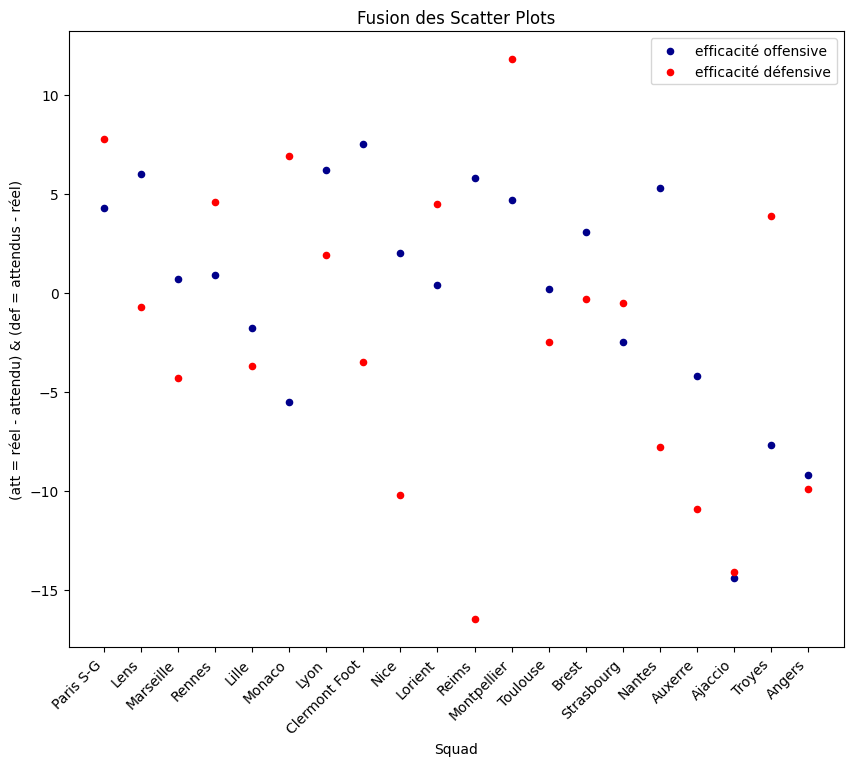

In [ ]:
8# Créer une figure avec un seul axe
fig, ax = plt.subplots(figsize=(10, 8))

# Premier scatter plot
dfE.sort_values(by=["Rk"]).plot.scatter(x='Squad', y='PSxG+/-', c='DarkBlue', ax=ax, label='efficacité offensive')

# Deuxième scatter plot
dfE.sort_values(by=["Rk"]).plot.scatter(x='Squad', y='G-xG', c='Red', ax=ax, label='efficacité défensive')

# Ajuster l'espacement des étiquettes sur l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Ajouter une légende
ax.legend()

# Ajouter des étiquettes et un titre
ax.set_xlabel('Squad')
ax.set_ylabel('(att = réel - attendu) & (def = attendus - réel)')
ax.set_title('Fusion des Scatter Plots')

# Afficher le graphique
plt.show()

Ici il n'y a pas l'air d'avoir de corélation, mais cette statistique est importante car elle rapelle qu'il a toujours un coté imprévisible au foot. Lens a su être plutôt efficace.

## b) Quel aurait été le classement selon les stats ?

Pour ce faire nous allons regardé d'après les statistiques qui aurait "dû" gagner les matchs

In [ ]:
dfE['xPts'] = pd.Series(dtype=int)

for i, squad in dfE.iterrows():
    xPts = 0
    for j, matchs in dfM.iterrows():
        if squad['Squad'] in matchs['HomeTeam']:
            if matchs['xRes'] == 'H':
                xPts += 3
            elif matchs['xRes'] == 'D':
                xPts += 1
        elif squad['Squad'] in matchs['AwayTeam']:
            if matchs['xRes'] == 'A':
                xPts += 3
            elif matchs['xRes'] == 'D':
                xPts += 1
    dfE.loc[dfE['Squad'] == squad['Squad'], 'xPts'] = xPts

In [ ]:
dfE_sorted = dfE.sort_values(by=["xPts"], ascending=False)

# Création de la colonne xRk initialisée à NaN
dfE['xRk'] = pd.Series(dtype=int)

# Attribuer les rangs en fonction de la position dans le classement
rank = 1
prev_pts = None
prev_rank = None
for index, row in dfE_sorted.iterrows():
    dfE.loc[dfE['Squad'] == row['Squad'], 'xRk'] = rank
    rank+=1

# Afficher le DataFrame avec les colonnes xPts et xRk
print(dfE[['Squad', 'xPts', 'xRk']].sort_values(by=["xPts"], ascending=False))


            Squad  xPts   xRk
6           Lille  70.0   1.0
14      Paris S-G  65.0   2.0
16         Rennes  62.0   3.0
5            Lens  60.0   4.0
10         Monaco  56.0   5.0
9       Marseille  55.0   6.0
8            Lyon  54.0   7.0
18       Toulouse  50.0   8.0
3           Brest  44.0   9.0
13           Nice  43.0  10.0
2         Auxerre  43.0  11.0
15          Reims  42.0  12.0
4   Clermont Foot  38.0  13.0
17     Strasbourg  36.0  14.0
12         Nantes  36.0  15.0
7         Lorient  35.0  16.0
11    Montpellier  34.0  17.0
0         Ajaccio  33.0  18.0
1          Angers  33.0  19.0
19         Troyes  32.0  20.0


Voici le classement selon les stats.

<ipython-input-240-3e3d23088287>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



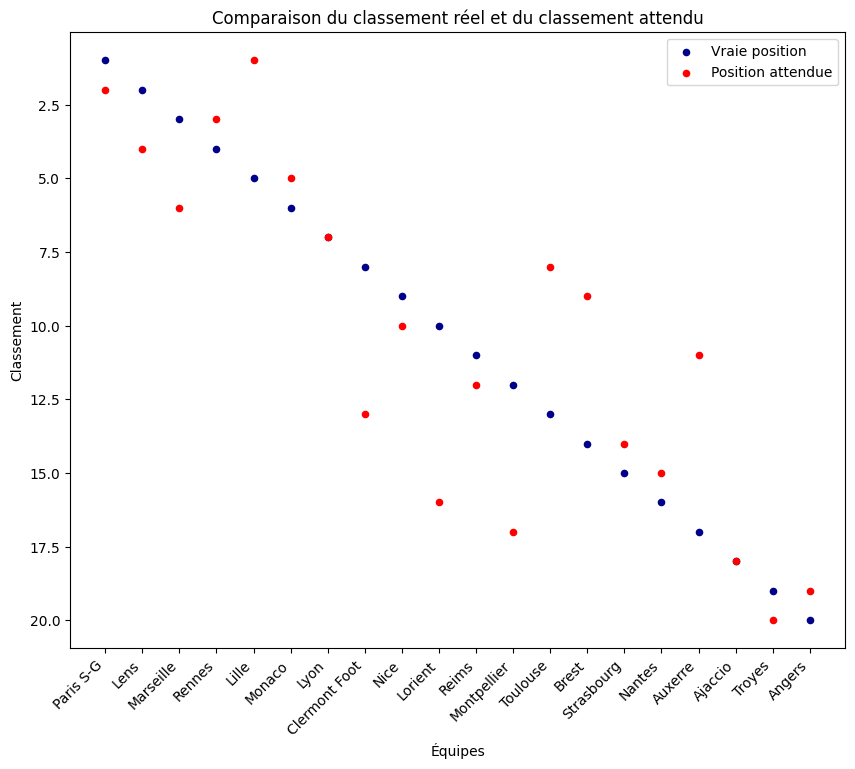

In [ ]:
import matplotlib.pyplot as plt

# Créer une figure avec un seul axe
fig, ax = plt.subplots(figsize=(10, 8))

# Premier scatter plot
dfE.sort_values(by=["Rk"]).plot.scatter(x='Squad', y='Rk', c='DarkBlue', ax=ax, label='Vraie position')

# Deuxième scatter plot
dfE.sort_values(by=["xRk"]).plot.scatter(x='Squad', y='xRk', c='Red', ax=ax, label='Position attendue')

# Tracer une ligne reliant deux points
# Supposons que vous vouliez relier le premier point de dfE['Rk'] au premier point de dfE['xRk']
ax.plot([dfE['Squad'].iloc[0], dfE['Squad'].iloc[0]], [dfE['Rk'].iloc[0], dfE['xRk'].iloc[0]], color='green')

# Ajuster l'espacement des étiquettes sur l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.invert_yaxis()
# Ajouter une légende
ax.legend()

# Ajouter des étiquettes et un titre
ax.set_xlabel('Équipes')
ax.set_ylabel('Classement')
ax.set_title('Comparaison du classement réel et du classement attendu')

# Afficher le graphique
plt.show()


Pour finir nous voyons donc ici que Lens a "surperformer" ce qui lui a permit de finir deuxième de ligue 1

# V) Conclusion

Tout d'abord nous aurions pu faire encore plus de graphique différent en fonction de la data obtenus. Nous aurions pu faire une Heat map en fonction de certains joueurs ou un graphique avec les schémas de passes voir même un graphique avec le momentum des équipes lors d'un match.
Pour revenir sur le RC lens qui est donc la meilleure défense de ligue 1, nous avons vu qu'en plus de bien défendre Lens a su être dangereux en attaque et se procurer de nombreuses occasions qui leur a permis de marquer beaucoup de buts. Comme le montrait la corrélation entre le nombre de buts marqués, le nombre de buts encaissés et la différence de buts avec le classement, le RC Lens a su appuyer là où il fallait.
